In [1]:
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
from torchvision.utils import make_grid, save_image
from torchvision import  transforms, models
from torch import nn
from XrayDataset import XrayDataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
import torch
import matplotlib.pyplot as plt
import numpy as np




Bad key "text.kerning_factor" on line 4 in
/home/ramkik/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
classes = ['normal', 'COVID-19', 'other_pneumonia']

In [3]:
checkpoint = 'checkpoint1'

In [4]:
model = models.resnet50(pretrained=True)

In [5]:
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 3))

In [6]:
checkpoint_path = 'ckpt-900.pth.tar'

In [7]:
checkpoint  = torch.load(checkpoint_path)

In [8]:
distributed_state_dict = checkpoint['state_dict']

In [9]:
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in distributed_state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

In [10]:
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [11]:
transform = transforms.Compose([   transforms.CenterCrop(280),
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor()
                                     
                                      ])

normalize =  transforms.Normalize(mean=[0.5], std=[0.5])
   

combined = transforms.Compose([transform, normalize])


In [12]:
train_dataset = XrayDataset( 'data', 'train', 'train.csv', transform )

test_dataset = XrayDataset('data', 'test', 'test.csv', transform )

In [13]:
batch_size = 1

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,  shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False, num_workers=4)

In [15]:

configs = [
    dict(model_type='resnet', arch=model, layer_name='layer4'),
]

In [16]:
for config in configs:
    config['arch'].cuda().eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

other_pneumonia


/home/ramkik/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


normal
other_pneumonia
other_pneumonia
normal
normal
other_pneumonia
normal
other_pneumonia
other_pneumonia
normal
COVID-19
other_pneumonia
COVID-19
normal
COVID-19
other_pneumonia
normal
COVID-19
other_pneumonia
other_pneumonia
COVID-19
20


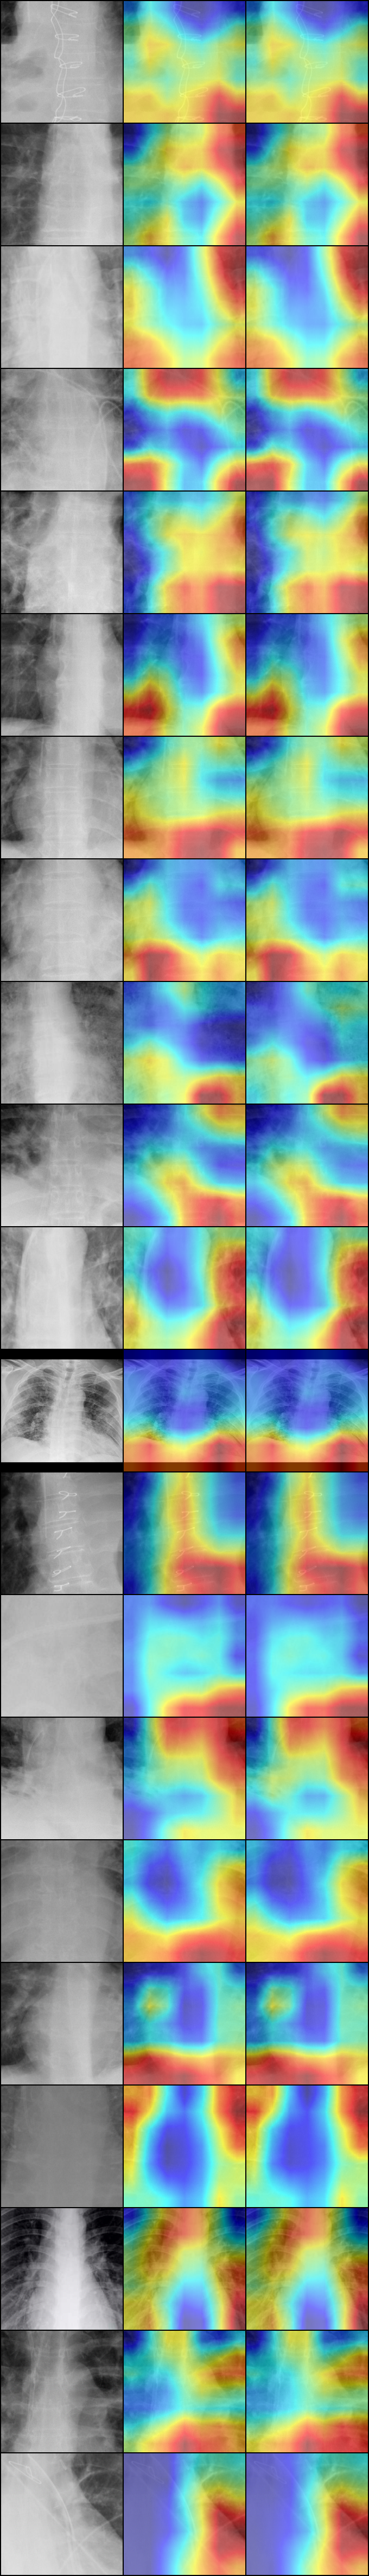

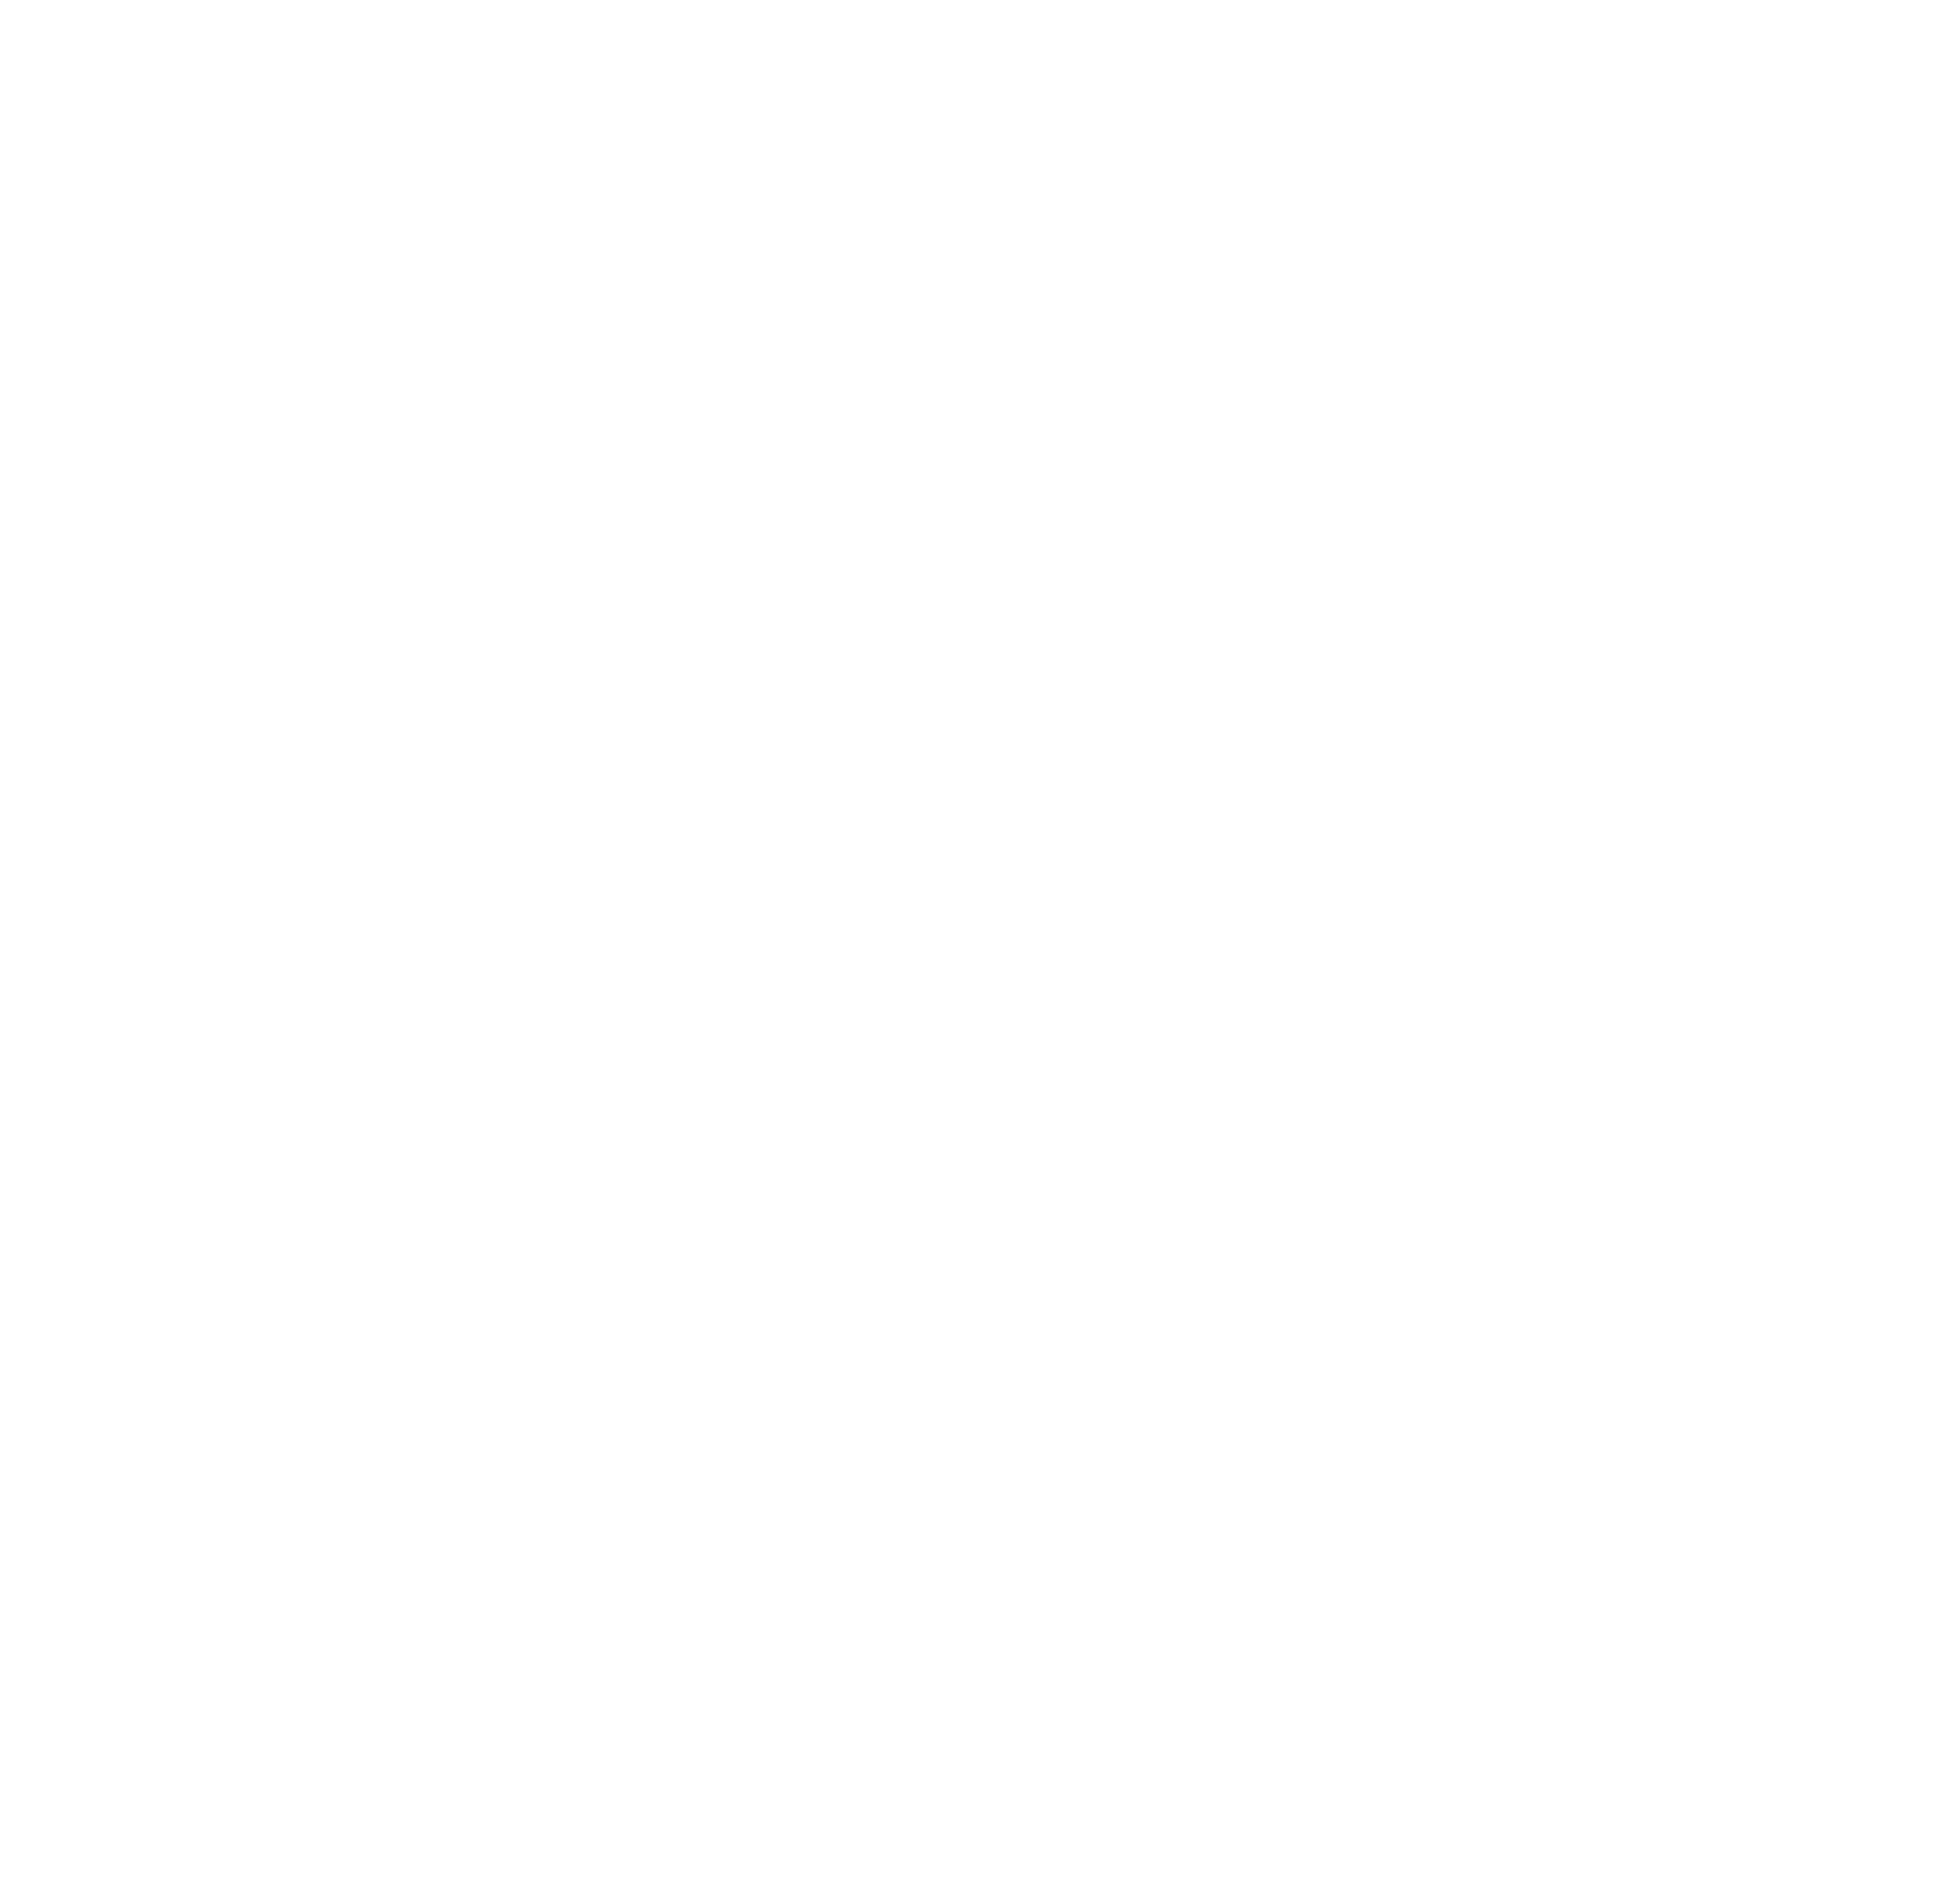

In [17]:
fig,axes = plt.subplots(nrows = 11, ncols = 1, figsize=(50,50))

for ax in axes.flatten():
    ax.axis('off')
    
a = False
count = -1

images = []

for inputs, labels in train_dataloader:
    print(classes[labels])
    if a==True:
        break
    count += 1
    if count==20:
        a= True
    inputs.squeeze_(0)
    #print(inputs.shape)

    normalizd = normalize(inputs)
    normalizd.unsqueeze_(0)
    if torch.cuda.is_available():
            normalizd, labels = normalizd.cuda(), labels.cuda()
            
    
    for gradcam, gradcam_pp in cams:
        mask, _ = gradcam(normalizd)
        heatmap, result = visualize_cam(mask, inputs)

        mask_pp, _ = gradcam_pp(normalizd)
        heatmap_pp, result_pp = visualize_cam(mask_pp, inputs)

        images.extend([inputs, result, result_pp])

#     for i in images:
#         print(i.shape)
grid_image = make_grid(images, nrow=3)
print(count)
#axes[count].imshow(grid_image.permute(1, 2, 0))
transforms.ToPILImage()(grid_image)
#plt.imshow(np.transpose(grid_image, (1,2,0)))
#plt.show()

In [18]:
class SaveFeatures(): 
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)  # attach the hook to the specified layer
        
    def hook_fn(self, module, input, output): 
        self.features = ((output.cpu()).data).numpy() # copy the activation features as an instance variable
        
    def remove(self): 
        self.hook.remove()

In [19]:
final_layer = model._modules.get('layer4') # Grab the final layer of the model
activated_features = SaveFeatures(final_layer) # attach the call back hook to the final layer of the model

In [20]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc.dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [21]:
weight_softmax_params = list(model._modules.get('fc').parameters()) 

In [22]:
print(weight_softmax_params[0].shape, weight_softmax_params[1].shape) # weghts for the last two layers

torch.Size([512, 2048]) torch.Size([512])


In [23]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

from captum.attr import GuidedGradCam

In [38]:
image, label = next(iter(train_dataset))
image = image.unsqueeze(0).cuda()
image.shape

torch.Size([1, 3, 224, 224])

In [39]:
label

0

In [40]:
output= model(image)
prediction_score, pred_label_idx = torch.topk(output, 1)


In [41]:
op

tensor([[-4.2210, -2.9852,  8.4597]], device='cuda:0', grad_fn=<AddmmBackward>)

In [42]:
pred_label_idx

tensor([[2]], device='cuda:0')

In [43]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(image, target=pred_label_idx, n_steps=200)

In [46]:
attributions_ig.shape

torch.Size([1, 3, 224, 224])

In [44]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

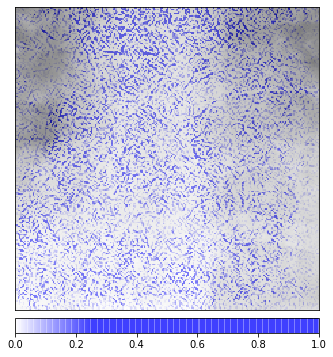

In [47]:
fig, axis= viz.visualize_image_attr(np.transpose(attributions_ig.view(3,224,224).cpu().detach().numpy(), (1,2,0)),
                             np.transpose(image.view(3,224,224).cpu().detach().numpy(), (1,2,0)),
                             method='blended_heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)